# Problem 5 - Learning Rate, Batch Size, FashionMNIST

## 5.1

In [35]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

In [36]:
# import the necessary packages
import os
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-10
MAX_LR = 1e+1
BATCH_SIZE = 64
STEP_SIZE = 5
CLR_METHOD = "triangular"
NUM_EPOCHS = 5

In [37]:
def create_lenet_model():
  model = Sequential([
    Conv2D(6, (5, 5), activation='tanh', input_shape=trainX.shape[1:]),
    AveragePooling2D(),
    Conv2D(16, (5, 5), activation='tanh'),
    AveragePooling2D(),
    Conv2D(120, (5, 5), activation='tanh'),
    Flatten(),
    Dense(84, activation='tanh'),
    Dense(10, activation='softmax')
    ])
  return model

In [38]:
resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

trainX = tf.pad(trainX, [[0, 0], [2,2], [2,2]])/255
testX = tf.pad(testX, [[0, 0], [2,2], [2,2]])/255

trainX = tf.expand_dims(trainX, axis=3, name=None)
testX = tf.expand_dims(testX, axis=3, name=None)

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...


In [39]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate = MIN_LR, momentum=0.9)
model = create_lenet_model()
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [40]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
        def __init__(self, model, stopFactor=4, beta=0.98):
                # store the model, stop factor, and beta value (for computing
                # a smoothed, average loss)
                self.model = model
                self.stopFactor = stopFactor
                self.beta = beta
                # initialize our list of learning rates and losses,
                # respectively
                self.lrs = []
                self.losses = []
                # initialize our learning rate multiplier, average loss, best
                # loss found thus far, current batch number, and weights file
                self.lrMult = 1
                self.avgLoss = 0
                self.bestLoss = 1e9
                self.batchNum = 0
                self.weightsFile = None

        def reset(self):
		# re-initialize all variables from our constructor
                self.lrs = []
                self.losses = []
                self.lrMult = 1
                self.avgLoss = 0
                self.bestLoss = 1e9
                self.batchNum = 0
                self.weightsFile = None

        def is_data_iter(self, data):
                # define the set of class types we will check for
                iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
                         "DataFrameIterator", "Iterator", "Sequence"]
                # return whether our data is an iterator
                return data.__class__.__name__ in iterClasses

        def on_batch_end(self, batch, logs):
                # grab the current learning rate and add log it to the list of
                # learning rates that we've tried
                lr = K.get_value(self.model.optimizer.lr)
                self.lrs.append(lr)
                # grab the loss at the end of this batch, increment the total
                # number of batches processed, compute the average average
                # loss, smooth it, and update the losses list with the
                # smoothed value
                l = logs["loss"]
                self.batchNum += 1
                self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
                smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
                self.losses.append(smooth)
                # compute the maximum loss stopping factor value
                stopLoss = self.stopFactor * self.bestLoss
                # check to see whether the loss has grown too large
                if self.batchNum > 1 and smooth > stopLoss:
                        # stop returning and return from the method
                        self.model.stop_training = True
                        return
                # check to see if the best loss should be updated
                if self.batchNum == 1 or smooth < self.bestLoss:
                        self.bestLoss = smooth
                # increase the learning rate
                lr *= self.lrMult
                K.set_value(self.model.optimizer.lr, lr)

        def find(self, trainData, startLR, endLR, epochs=None,
                stepsPerEpoch=None, batchSize=32, sampleSize=2048,
                verbose=1):
                # reset our class-specific variables
                self.reset()
                # determine if we are using a data generator or not
                useGen = self.is_data_iter(trainData)
                # if we're using a generator and the steps per epoch is not
                # supplied, raise an error
                if useGen and stepsPerEpoch is None:
                        msg = "Using generator without supplying stepsPerEpoch"
                        raise Exception(msg)
                # if we're not using a generator then our entire dataset must
                # already be in memory
                elif not useGen:
                        # grab the number of samples in the training data and
                        # then derive the number of steps per epoch
                        numSamples = len(trainData[0])
                        stepsPerEpoch = np.ceil(numSamples / float(batchSize))
                # if no number of training epochs are supplied, compute the
                # training epochs based on a default sample size
                if epochs is None:
                        epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
                # compute the total number of batch updates that will take
                # place while we are attempting to find a good starting
                # learning rate
                numBatchUpdates = epochs * stepsPerEpoch
                # derive the learning rate multiplier based on the ending
                # learning rate, starting learning rate, and total number of
                # batch updates
                self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
                # create a temporary file path for the model weights and
                # then save the weights (so we can reset the weights when we
                # are done)
                self.weightsFile = tempfile.mkstemp()[1]
                self.model.save_weights(self.weightsFile)
                # grab the *original* learning rate (so we can reset it
                # later), and then set the *starting* learning rate
                origLR = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, startLR)
                # construct a callback that will be called at the end of each
                # batch, enabling us to increase our learning rate as training
                # progresses
                callback = LambdaCallback(on_batch_end=lambda batch, logs:
                        self.on_batch_end(batch, logs))
                # check to see if we are using a data iterator
                if useGen:
                        self.model.fit(
                                x=trainData,
                                steps_per_epoch=stepsPerEpoch,
                                epochs=epochs,
                                verbose=verbose,
                                callbacks=[callback])
                # otherwise, our entire training data is already in memory
                else:
                        # train our model using Keras' fit method
                        self.model.fit(
                                x=trainData[0], y=trainData[1],
                                batch_size=batchSize,
                                epochs=epochs,
                                callbacks=[callback],
                                verbose=verbose)
                # restore the original model weights and learning rate
                self.model.load_weights(self.weightsFile)
                K.set_value(self.model.optimizer.lr, origLR)

        def plot_loss(self, skipBegin=10, skipEnd=10, title=""):
                # grab the learning rate and losses values to plot
                lrs = self.lrs[skipBegin:-skipEnd]
                losses = self.losses[skipBegin:-skipEnd]
                # plot the learning rate vs. loss
                plt.plot(lrs, losses)
                plt.xscale("log")
                plt.xlabel("Learning Rate (Log Scale)")
                plt.ylabel("Loss")
                # if the title is not empty, add it to the plot
                if title != "":
                        plt.title(title)

[INFO] finding learning rate...
Epoch 1/5
938/938 [==============================] - 49s 52ms/step - loss: 2.3166 - accuracy: 0.0489
Epoch 2/5
938/938 [==============================] - 48s 51ms/step - loss: 2.3173 - accuracy: 0.0492
Epoch 3/5
938/938 [==============================] - 49s 52ms/step - loss: 2.2931 - accuracy: 0.0899
Epoch 4/5
938/938 [==============================] - 48s 51ms/step - loss: 1.2071 - accuracy: 0.5742
Epoch 5/5
938/938 [==============================] - 24s 26ms/step - loss: 7.7273 - accuracy: 0.5402
[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


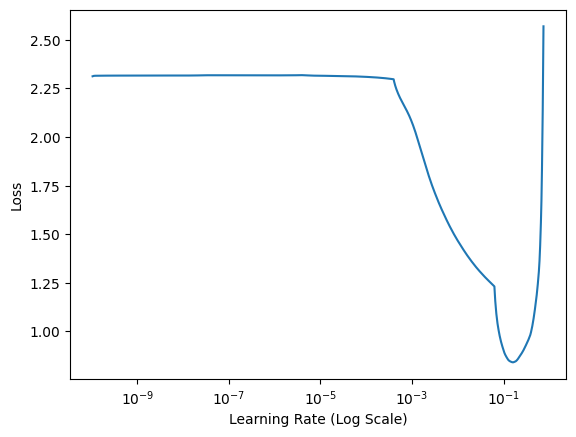

In [41]:
# initialize the learning rate finder and then train with learning rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
		aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))), epochs = NUM_EPOCHS,
		batchSize = BATCH_SIZE)
# plot the loss for the various learning rates and save the resulting plot to disk
lrf.plot_loss()
plt.savefig('LRFINDER.png')
# gracefully exit the script so we can adjust our learning rates in the config and then train the network for our full set of epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")
sys.exit(0)

**Answer:**
- **lr(min)** should be a value corresponding to the learning rate where the loss reaches its lowest point before the first sharp increase. From the graph, this appears to be somewhere close to 10^-3.
- **lr(max)** should be a value slightly before the loss begins its sharp increase. From the graph, this seems to be just around 10^-2, yet certainly less than 1.

## 5.2

In [42]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

In [43]:
MIN_LR = 1e-3
MAX_LR = 1e-2

# otherwise, we have already defined a learning rate space to train over, so compute the step size and initialize the cyclic learning rate method
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=stepSize)

# train the network
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
	validation_data = (testX, testY),
	steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
	epochs = NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x = testX, batch_size = BATCH_SIZE)
print(classification_report(testY.argmax(axis = 1),
	predictions.argmax(axis=1), target_names = CLASSES))

Epoch 1/5
937/937 [==============================] - 54s 58ms/step - loss: 2.4427 - accuracy: 0.2111 - val_loss: 1.6665 - val_accuracy: 0.3406
Epoch 2/5
937/937 [==============================] - 50s 54ms/step - loss: 1.2248 - accuracy: 0.5611 - val_loss: 0.9534 - val_accuracy: 0.6299
Epoch 3/5
937/937 [==============================] - 52s 56ms/step - loss: 0.9164 - accuracy: 0.6574 - val_loss: 0.7938 - val_accuracy: 0.6945
Epoch 4/5
937/937 [==============================] - 51s 54ms/step - loss: 0.8382 - accuracy: 0.6821 - val_loss: 0.6853 - val_accuracy: 0.7357
Epoch 5/5
937/937 [==============================] - 51s 54ms/step - loss: 0.7600 - accuracy: 0.7118 - val_loss: 0.6691 - val_accuracy: 0.7591
[INFO] evaluating network...
157/157 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

         top       0.76      0.76      0.76      1000
     trouser       0.99      0.95      0.97      1000
    pullover       0.46      0.78    

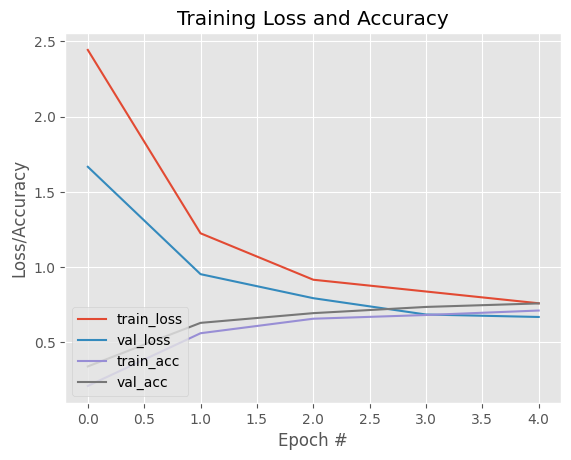

In [46]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

**Answer:**
- As the epochs increase, both the training and validation losses decrease, indicating an improvement in the model's performance.
- However, after a certain point, the validation loss starts to plateau, hinting at potential overfitting.
- The accuracies of both training and validation sets improve, but the growing gap between them further supports the concept of overfitting.

## 5.3

Epoch 1/5
1875/1875 [==============================] - 58s 30ms/step - loss: 0.7745 - accuracy: 0.7036 - val_loss: 0.5982 - val_accuracy: 0.7658
Epoch 2/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.5435 - accuracy: 0.7931 - val_loss: 0.4812 - val_accuracy: 0.8161
Epoch 3/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.4754 - accuracy: 0.8211 - val_loss: 0.4245 - val_accuracy: 0.8372
Epoch 4/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.4410 - accuracy: 0.8333 - val_loss: 0.3892 - val_accuracy: 0.8525
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.4190 - accuracy: 0.8423 - val_loss: 0.3970 - val_accuracy: 0.8437
Epoch 1/5
937/937 [==============================] - 51s 54ms/step - loss: 0.3727 - accuracy: 0.8595 - val_loss: 0.3635 - val_accuracy: 0.8614
Epoch 2/5
937/937 [==============================] - 49s 52ms/step - loss: 0.3628 - accuracy: 0.8651 - val_loss: 0.3507 - val_accura

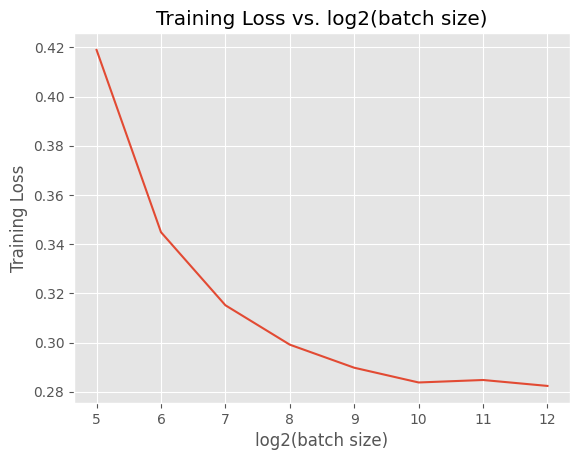

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import keras

# Given variables
batch_sizes = [2**i for i in range(5, 13)]  # [32, 64, 128, ..., 4096]
losses = []

model = create_lenet_model()
model.compile(optimizer=keras.optimizers.SGD(learning_rate=MAX_LR, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

for batch_size in batch_sizes:
    history = model.fit(x=aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), steps_per_epoch=trainX.shape[0]//batch_size, epochs=5)
    losses.append(history.history['loss'][-1])

# Plotting
plt.plot(np.log2(batch_sizes), losses)
plt.xlabel('log2(batch size)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. log2(batch size)')
plt.grid(True)
plt.show()

**Answer:**

- The graph depicts a clear trend of decreasing training loss as the log2(batch size) increases, indicating that as the batch size increases, the model's error on the training data reduces.
- The reduction in training loss appears relatively smooth. This could suggest that the increase in batch size consistently benefits the training phase, leading to a steady decline in the training error.
- As batch size increases, more samples are used to compute the gradient in each update. This often results in a more stable gradient estimate and less noise, which might explain the decline in training loss. However simultaneously, using very large batch sizes might lead to overfitting as the model might start to memorize the training data over time.

**Comparison with Cyclical Learning Rate Policy:**
- The cyclical learning rate policy: adjusts the learning rate during training, which balances exploration and exploitation. This therefore helps in preventing the model from getting stuck in local minima and ensures an overall smoother convergence.
- In contrast, increasing the batch size while keeping the learning rate fixed focuses on the stability that comes with batch size increase.
- As seen in the graph, the training loss decreases as the batch size increases. This inverse relationship for this particular model and dataset means that an increase in batch size is indeed beneficial for reducing the training error.